imports

In [ ]:
import torch
import os
import numpy as np
from tqdm import tqdm

import pandas as pd

from myhelpers import cifar_dataLoader

from HGNN.train.configParser import ConfigParser
from HGNN.train import CNN, dataLoader
from myhelpers.memory import get_cuda_memory
from myhelpers.image_show import showExample, getClosestImageFromDataloader
from myhelpers.images_tsne import get_tsne
from misc import get_classification_df
from PIL import Image
from torchvision import transforms as torchvision_transforms

experimetnsFileName = "experiments.csv"

parameters

In [ ]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish/"
experimentName="Fish30-5run-PhyloNN6"#"Fish-L1-experiment2"#"CIFAR_phylogeny_HGNN_lambdaExperiment"
# trial_hash="27a4da8bf0c3bca7096cddf192ecf3069e035ad3fbba69bbd47bd157" #MSE + L1
#"5922bad3c69f629daa0af24121e292a895f308e7cae3ec4f64536186"#hier
trial_hash="0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4" #PhyloNN
SEED_INT=4 # order of the trial_hash when executed

layer= 'layer2' #'gap_features'

#random image if None. Otherwise, the path
init_image ="test/Notropis buchanani/INHS_FISH_108458.jpg" 
# init_image = None


# name of image the features of which we will mimic. 
# image_of_features="test/Notropis buchanani/INHS_FISH_102641.jpg" # same species
# image_of_features = "test/Notropis telescopus/INHS_FISH_87353.jpg" # close species
image_of_features = "test/Lepisosteus platostomus/INHS_FISH_87088.jpg" # far species
# image_of_features = "test/Notropis buccatus/dog-puppy-on-garden-royalty-free-image-1586966191.jpg" # dog #TODO: DELETE THIS IMAGE FROM SERVER
# If there is a <name>_<layer>_features.py file exists, it will load. This can be used to load any artificially constructed embedding value
# If that file does not exist, then load the image, create the embedding, and save the file

tv_lambda=0
max_iter = 500
cuda=0

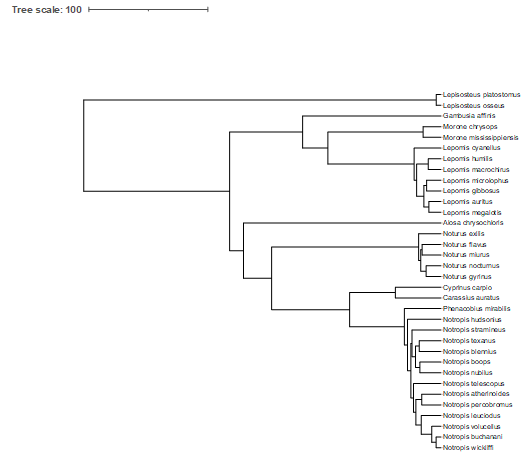

Show example and closest images

cuda

In [ ]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)
    
torch.multiprocessing.set_start_method('spawn')

Get dataset

In [ ]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
    experiments_df = experiments_df.where(pd.notnull(experiments_df), None)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experiment_params = config_parser.fixExperimentParams(experiment_params)
experimentPathAndName = os.path.join(experimentsPath, experimentName)
if experiment_params['image_path'] == 'cifar-100-python':
    datasetManager = cifar_dataLoader.datasetManager(experimentPathAndName, dataPath)
else:
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders(SEED_INT)

# dataloader = torch.utils.data.DataLoader(test_loader.dataset if dataset_name=="test" else train_loader.dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers)
# dataset = dataloader.dataset

Get untrained model

In [ ]:
%%capture

# architecture = {
#     "fine": len(dataset.csv_processor.getFineList()),
#     "coarse" : len(dataset.csv_processor.getCoarseList())
# }
architecture = CNN.get_architecture(experiment_params, train_loader.dataset.csv_processor)
model = CNN.create_model(architecture, experiment_params, cuda)

# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)
_ = CNN.loadModel(model, trialName)
model.eval()

Use reverse image
#From https://github.com/paulu/deepfeatinterp/blob/76b72e0a3b683a8cdeb13ed35b932680dc159ed1/deepmodels_torch.py

In [ ]:
def getTransformedImage(dataset, img, augmentation, normalization):
    augmentation2, normalization2, pad2 = dataset.toggle_image_loading(augmentation=augmentation, normalization=normalization)
    transforms = dataset.getTransforms()
    composedTransforms = torchvision_transforms.Compose(transforms)
    img_clone = composedTransforms(img)
#     print(img_clone.shape)
#     img_clone = img_clone.unsqueeze(0)
#     print(img_clone.shape)
    dataset.toggle_image_loading(augmentation2, normalization2, pad2)
    return img_clone

In [ ]:
def get_init_image(experiment_params, init_image, loader):
    if init_image is None:
        x = torch.rand((3, experiment_params['img_res'], experiment_params['img_res']))
#         x = torch.from_numpy(x)
        original = x.permute(1,2,0)
        original = original.detach().numpy()
        original = original* 255
        original = original.astype(np.uint8)
        original = Image.fromarray(original)
    else:
#         title = ntpath.basename(init_image)
        init_image_ = os.path.join(dataPath, experiment_params["image_path"], init_image)
        original = Image.open(init_image_)
    #     image_non_normalized = getTransformedImage(test_loader.dataset, original, False, False)
        x = getTransformedImage(test_loader.dataset, original, False, True)
#         print('x', x.shape)
    
    if cuda is not None:
        x = x.cuda()
    
    return x, original

In [ ]:
def get_dest_embedding(experiment_params, image_of_features, model, layer):
    embedding_file_name = "features_"+layer+"_"+image_of_features.replace('/', '_')+".py"
    embedding_dir = os.path.join(trialName, 'embeddings')
    embedding_file =  os.path.join(embedding_dir, embedding_file_name)
    
    image_file = os.path.join(dataPath, experiment_params["image_path"], image_of_features)
    img_ = Image.open(image_file)
    
    if os.path.exists(embedding_file):
        F = torch.load(embedding_file)
        print('file loaded:',embedding_file)
    else:
        img_ = getTransformedImage(test_loader.dataset, img_, False, True)
        img_ = img_.unsqueeze(0)
        if cuda is not None:
            img_ = img_.cuda()
        F = model.activations(img_)[layer]
        if not os.path.exists(embedding_dir):
            os.mkdir(embedding_dir)
        torch.save(F, embedding_file)
        print('file saved:',embedding_file)
        
    return F, img_
                       

In [ ]:
intervals = [0, int(0.25*512), int(0.5*512), int(0.75*512), 512]
phylo_caps = [0.5, 0.3, 0.1, 0]

def print_features(f, title):
    print('features of ' + title)
    for i in range(len(intervals)-1):
        print(intervals[i], '-', intervals[i+1], ':',  f.view(-1)[intervals[i]:intervals[i+1]])
    print('---')
    
def print_dist(f1, f2):
    print('cosine distances between two embeddings')
    for i in range(len(intervals)-1):
        b = intervals[i]
        e = intervals[i+1]
        d1 = f1[:, b:e].view(1,-1)
        d2 = f2[:, b:e].view(1,-1)
        target_cosine = torch.ones(d1.size(0))
        if cuda is not None:
            target_cosine = target_cosine.cuda()
        print('distance(', b, '-', e, '):',  torch.nn.CosineEmbeddingLoss()(d1, d2, target_cosine).item())
    print('---')

In [ ]:
class TVLoss(torch.nn.Module):
    def __init__(self, eps=1e-3, beta=2):
        super(TVLoss, self).__init__()
        self.eps = eps
        self.beta = beta

    def forward(self, input):
        x_diff = input[:, :, :-1, :-1] - input[:, :, :-1, 1:]
        y_diff = input[:, :, :-1, :-1] - input[:, :, 1:, :-1]

        sq_diff = torch.clamp(x_diff * x_diff + y_diff * y_diff, self.eps, 10000000)
        return torch.norm(sq_diff, self.beta / 2.0) ** (self.beta / 2.0)

In [ ]:
destination = None

if cuda is not None:
    model = model.cuda()



x, original = get_init_image(experiment_params, init_image, test_loader)

# x = model(x)
x = x.contiguous().view(1, *x.size())
recon_var = torch.nn.Parameter(x.cuda(), requires_grad = True)
# Get size of features
orig_feature_vars = model.activations(recon_var)[layer]

F, destination = get_dest_embedding(experiment_params, image_of_features, model, layer)

# I fyou wanna use a constant artificial descriptor for destination
# # ones_ = torch.ones((128))
# ones_ = torch.zeros((128))
# # print(ones_.shape)
# # print(orig_feature_vars[:, 128:512].view(-1).shape)
# if cuda is not None:
#     ones_ = ones_.cuda()
# F = torch.autograd.Variable(torch.cat((ones_, orig_feature_vars[:, 128:512].view(-1))).unsqueeze(0))
# # print(F.shape)
    

# x = x.permute(2, 0, 1)
orig_size = x.size()



# sizes = ([f.data[:1].size() for f in orig_feature_vars])
# cat_offsets = torch.cat([torch.Tensor([0]), torch.cumsum(torch.Tensor([f.data[:1].nelement() for f in orig_feature_vars]), 0)])

# Reshape provided features to match original features
# cat_features = torch.from_numpy(F).view(-1)
# features = tuple(Variable(cat_features[int(start_i):int(end_i)].view(size)).cuda()
#   for size, start_i, end_i in zip(sizes, cat_offsets[:-1], cat_offsets[1:]))
features = F

# print embeddings
print_features(orig_feature_vars, 'current features')
print_features(features, 'destination features')
print_dist(orig_feature_vars, features)


# Create optimizer and loss functions
optimizer = torch.optim.LBFGS(
  params = [recon_var],
  max_iter = max_iter,
)
optimizer.n_steps = 0
criterion = torch.nn.MSELoss(reduction  = 'sum')
# criterion = torch.nn.CosineEmbeddingLoss()
criterion_tv = TVLoss()
if cuda is not None:
    criterion = criterion.cuda()
    criterion_tv = criterion_tv.cuda()

# Optimize
def step():
    model.zero_grad()
    if recon_var.grad is not None:
        recon_var.grad.data.fill_(0)

    output_var = model.activations(recon_var)[layer]
    loss1 = criterion(output_var, features)
#     target_cosine = torch.ones(output_var.size(0))
#     if cuda is not None:
#         target_cosine = target_cosine.cuda()
#     loss1 = criterion(output_var, features,target_cosine)
#     loss4 = criterion4(output_var[1], features[1])
#     loss5 = criterion5(output_var[2], features[2])
    loss_tv = tv_lambda * criterion_tv(recon_var)
    loss = loss1 + loss_tv
    loss.backward(retain_graph=True)

    if optimizer.n_steps % 25 == 0:
        print('Step: %d  total: %.5f  mse: %.5f  tv: %.5f' %
          (optimizer.n_steps, loss.item(), loss1.item(), loss_tv.item()))

    optimizer.n_steps += 1
    return loss

optimizer.step(step)
# self.forward_model.cpu()
recon = recon_var.data[0].cpu()

# Return the new image
# recon = self.reverse_transform(recon)
plt_img = test_loader.dataset.denormalizer(recon)
# print('plt_img1', plt_img.shape)

plt_img = plt_img.squeeze().permute(1,2,0)
plt_img = torch.clip(plt_img, min=0, max=1)
plt_img = plt_img.detach().numpy()
plt_img = plt_img* 255
plt_img = plt_img.astype(np.uint8)
plt_img = Image.fromarray(plt_img)

# get new emnbedding
temp_ = getTransformedImage(test_loader.dataset, plt_img, False, True)
if cuda is not None:
    temp_ = temp_.cuda()
temp_ = model.activations(temp_.unsqueeze(0))[layer]
print_dist(temp_, features)
    
# recon = unfit_from_quantum(recon, orig_size)
# recon = recon.squeeze()
# recon = recon.permute(1, 2, 0)
# return recon.numpy()
# plt_img

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Add padding
original_ = getTransformedImage(test_loader.dataset, original, False, True)
original_ = test_loader.dataset.denormalizer(original_)
original_ = original_.squeeze().permute(1,2,0)
original_ = torch.clip(original_, min=0, max=1)
original_ = original_.detach().numpy()
original_ = original_* 255
original_ = original_.astype(np.uint8)
original_ = Image.fromarray(original_)

f, axarr = plt.subplots(1,3,figsize=(30,30))
axarr[0].imshow(plt_img)
axarr[1].imshow(original_)
axarr[2].imshow(destination)
axarr[0].title.set_text('Generated')
axarr[1].title.set_text('Original')
axarr[2].title.set_text('Target')
axarr[0].axes.xaxis.set_ticks([])
axarr[0].axes.yaxis.set_ticks([])
axarr[1].axes.xaxis.set_ticks([])
axarr[1].axes.yaxis.set_ticks([])
axarr[2].axes.xaxis.set_ticks([])
axarr[2].axes.yaxis.set_ticks([])


In [ ]:
from PIL import ImageChops
import PIL.ImageOps 

print('diff between initial and generated images')
diff = PIL.ImageOps.invert(ImageChops.difference(original_, plt_img))
diff

In [ ]:
np.array(diff)
np.max(diff)

In [ ]:
model.activations(recon_var)

In [ ]:
b = torch.rand(1, 4)
print(b.shape)
a = torch.rand(1, 4)
print(b.shape)
c = torch.cat([a, b], dim=1)
print(c.shape)